**Curve Fitting**

It can be usefull to go from one soil model to the other. When the soil parameters are known the soil water retention curve and hydraulic conductivity function can be fitted.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pedon as pe

In [2]:
def plot_compare(soilsample: pe.SoilSample, soilmodel: pe.soilmodel.SoilModel):
    f, ax = plt.subplots(1, 2, sharey=True, figsize=(4.2, 4.5))
    ax[0].scatter(soilsample.theta, soilsample.h, c="k", s=10, label="Soil Sample")
    _ = pe.soilmodel.plot_swrc(
        soilmodel, ax=ax[0], label=f"Fitted Soil Model {soilmodel.__class__.__name__}"
    )
    ax[0].set_yscale("log")
    ax[0].set_xlim(0, 0.5)
    ax[0].set_yticks(soilsample.h)
    ax[0].set_xticks(np.linspace(0, 0.5, 6))

    ax[1].scatter(soilsample.k, soilsample.h, c="k", s=10)
    _ = pe.soilmodel.plot_hcf(soilmodel, ax=ax[1])

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    k_left = 10 ** (np.floor(np.log10(min(soilsample.k))) - 1)
    k_right = 10 ** (np.ceil(np.log10(max(soilsample.k))) + 1)
    ax[1].set_xlim(k_left, k_right)
    ax[0].set_ylabel(r"|$\psi$| [cm]")
    ax[0].set_xlabel(r"$\theta$ [-]")
    ax[1].set_xlabel(r"$K_s$ [cm/d]")
    ncol = 3
    ax[0].legend(
        loc=(-0.02, 1),
        fontsize=6,
        frameon=False,
        ncol=ncol,
        columnspacing=0.8,
        handlelength=2.5,
    )

    f.align_xlabels()
    # plt.close(f)

In [3]:
sn = "Sand"
soil = pe.Soil(sn).from_name(pe.Genuchten, "HYDRUS")
soilm_genuchten = getattr(soil, "model")
soilm_genuchten

Genuchten(k_s=712.8, theta_r=0.045, theta_s=0.43, alpha=0.145, n=2.68, l=0.5)

In [4]:
h = np.logspace(-4, 6, num=11)
k = soilm_genuchten.k(h)
theta = soilm_genuchten.theta(h)

In [5]:
soilsample = pe.SoilSample(h=h, k=k, theta=theta)
soilsample

SoilSample(sand_p=None, silt_p=None, clay_p=None, rho=None, th33=None, th1500=None, om_p=None, m50=None)

In [6]:
soilm_panday = soilsample.fit(
    pe.Panday,
)
soilm_panday

Panday(k_s=572.4421544309812, alpha=0.1461730507877064, beta=2.6528189773626414, brook=3.7982278651292423, sr=0.10452908337641295)

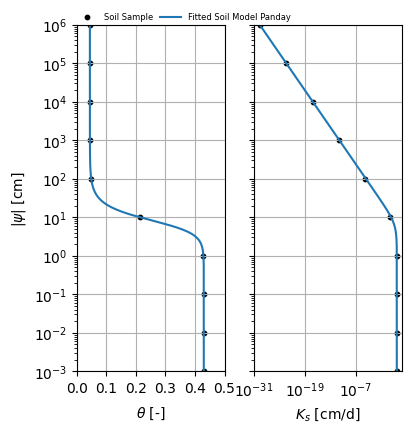

In [7]:
plot_compare(soilsample, soilm_panday)

The fit method finds the optimal curve through both the soil water retention curve and hydraulic conductivity function at the same time using the least squares algorithm. All parameters are subject to the optimization algorithm.

The fit method uses the optimization algorithm from the 1991 [RETC Code for Quantifying the Hydraulic Functions of Unsaturated Soils](https://www.pc-progress.com/Documents/programs/retc.pdf) by M.Th. van Genuchten, F.J. Leij and S.R. Yates.

The objective function $O(b)$ minimized is:

$ O(b) = \sum^N_{i=1}(w_i(\theta_{o,i}-\theta_i))^2 + \sum^M_{i=N+1}(w_iW_1W_2(Y_{o,i}-Y_i))^2$

Using the SciPy least-squares algorithm. 

With $N$ the number of $\theta$ data points and $M$ is the number of $K$ and $\theta$ data points

$w_i$ are the individual weight factors per measurements (by default 1 for each measurement)

$W_1$ is the weight factor for the hydraulic conductivity function with respect to the soil water retention (default is 0.1)

$W_2$ is the proportional weight factor for two different data types and elimination factor for different units. By default the formulation for 
$W_2 = \frac{(M-N)\sum^N_{i=1}w_i\theta_{o,i}}{N\sum^M_{i=N+1}w_i|Y_{o,i}|}$.

$Y$ is indicates the  for the logaritmic transform of such that $Y = log_{10}K$.

It can be favorable to only optimize the relative hydraulic conductivity function, and leave parameter k_s untouched. That kan be achieved by providing `k_s` to the fit method.

In [8]:
soilm_panday = soilsample.fit(pe.Panday, k_s=max(soilsample.k))
soilm_panday

Panday(k_s=712.7999894094452, alpha=0.14656691408919914, beta=2.643965735144585, brook=3.8329491617518454, sr=0.10448779206704849)

It is also possible to provide bounds for the parameter space. By default, the bounds argument is `None` which takes the stored parameter bounds per soil model:

In [ ]:
panday_bounds = pe.get_params("Panday")
panday_bounds

,p_ini,p_min,p_max,swrc
k_s,50.00,0.00100,100000.0,False
theta_r,0.02,0.00001,0.2,True
theta_s,0.40,0.20000,0.5,True
alpha,0.02,0.00100,0.3,True
beta,2.30,1.00000,12.0,True
brook,10.00,1.00000,50.0,False


In [10]:
panday_bounds.loc["k_s", "p_min"] = 650
panday_bounds.loc["k_s", "p_ini"] = max(soilsample.k)
soilm_panday = soilsample.fit(pe.Panday, pbounds=panday_bounds)
soilm_panday

Panday(k_s=650.0027068392608, alpha=0.14640200236757875, beta=2.6476559118830254, brook=3.8183761786812824, sr=0.10450508901642255)

Other available option are to print the optimization result.

In [11]:
soilm_panday = soilsample.fit(pe.Panday, silent=False)

SciPy Optimization Result
      message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 2.206e-05  2.206e-05 ... -9.025e-05 -2.615e-04]
           x: [ 5.724e+02  4.495e-02  4.300e-01  1.462e-01  2.653e+00
                3.798e+00]
        cost: 5.483425529890278e-07
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [ 1.944e-06  0.000e+00 ... -4.053e-02 -1.764e-02]
               [ 1.944e-06  0.000e+00 ... -5.026e-02 -2.187e-02]]
        grad: [ 1.672e-14  3.403e-09 -3.531e-10  5.768e-09  1.080e-09
                5.588e-11]
  optimality: 1.7851416034930158e-09
 active_mask: [0 0 0 0 0 0]
        nfev: 10
        njev: 10


To parse other parameters for W1, W2, and individual weights there are other keyword arguements that for the fit method.